In [117]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-recognition/sampleSubmission.csv
/kaggle/input/fruit-recognition/test/test/0664.jpg
/kaggle/input/fruit-recognition/test/test/1269.jpg
/kaggle/input/fruit-recognition/test/test/3863.jpg
/kaggle/input/fruit-recognition/test/test/2193.jpg
/kaggle/input/fruit-recognition/test/test/0733.jpg
/kaggle/input/fruit-recognition/test/test/3750.jpg
/kaggle/input/fruit-recognition/test/test/2008.jpg
/kaggle/input/fruit-recognition/test/test/2081.jpg
/kaggle/input/fruit-recognition/test/test/0106.jpg
/kaggle/input/fruit-recognition/test/test/0375.jpg
/kaggle/input/fruit-recognition/test/test/3919.jpg
/kaggle/input/fruit-recognition/test/test/3757.jpg
/kaggle/input/fruit-recognition/test/test/4489.jpg
/kaggle/input/fruit-recognition/test/test/3138.jpg
/kaggle/input/fruit-recognition/test/test/3417.jpg
/kaggle/input/fruit-recognition/test/test/5307.jpg
/kaggle/input/fruit-recognition/test/test/5039.jpg
/kaggle/input/fruit-recognition/test/test/4407.jpg
/kaggle/input/fruit-recogniti

In [118]:
import numpy as np
import pandas as pd

In [119]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [120]:
data_dir = '/kaggle/input/fruit-recognition/train/train'

dataset = datasets.ImageFolder(root=data_dir)

In [121]:
len(dataset)

16854

In [122]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=100x100>, 0)

In [123]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [124]:
image_tensor, label = dataset[0]

In [125]:
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(15)),
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset.classes
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [126]:
len(train_data), len(val_data)

(13484, 3370)

In [127]:
dataset = TransformDataset(dataset, transform=train_transform)

In [128]:
batch_size = 32

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

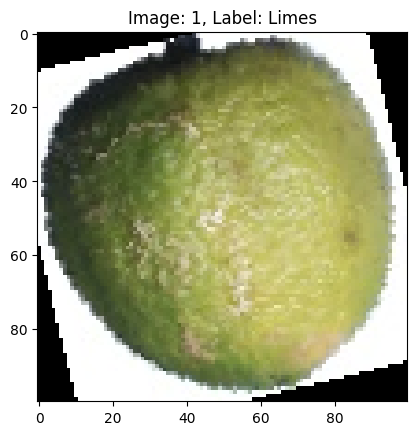

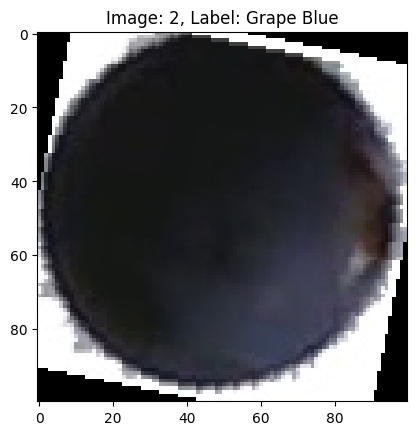

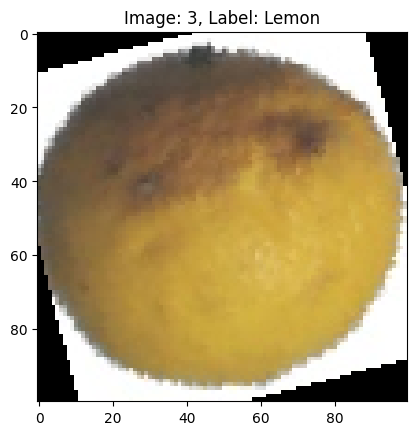

In [129]:
import matplotlib.pyplot as plt
import random

for i in range(3):  # Show 3 images
    rand = random.randint(0, 10661) 
    img, label = dataset[rand]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

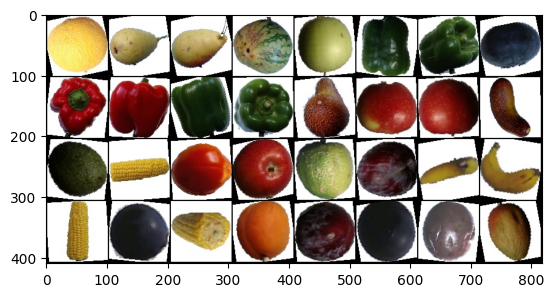

In [130]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)
  
batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)

In [131]:
batch.shape

torch.Size([32, 3, 100, 100])

In [132]:
import numpy as np
from torch import nn
import torch.nn.functional as F

class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(32*4*4, num_classes)
        

    def forward(self, x):
        out = self.conv1(x) 
        out = F.relu(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out) 
    
        out = self.conv3(out) 
        out = F.relu(out)
        
        out = self.pool2(out)
        
        out = self.conv4(out) 
        out = F.relu(out)
        
        out = self.pool3(out) 
        
        out = self.conv5(out) 
        out = F.relu(out)
        
        out = self.pool4(out)
        
        out = self.flat(out) 
        
        out = self.linear(out)
        
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()
    
model = FractureClassifier(len(train_data.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=512, out_features=33, bias=True)
)

In [133]:
!pip install -q torchsummary

In [134]:
from torchsummary import summary

summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 98, 98]             224
            Conv2d-2           [-1, 16, 96, 96]           1,168
         MaxPool2d-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 32, 46, 46]           4,640
         MaxPool2d-5           [-1, 32, 23, 23]               0
            Conv2d-6           [-1, 32, 21, 21]           9,248
         MaxPool2d-7           [-1, 32, 10, 10]               0
            Conv2d-8             [-1, 32, 8, 8]           9,248
         MaxPool2d-9             [-1, 32, 4, 4]               0
          Flatten-10                  [-1, 512]               0
           Linear-11                   [-1, 33]          16,929
Total params: 41,457
Trainable params: 41,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/ba

In [135]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [136]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [138]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=FractureClassifier, opt=Adam(lr=0.001000), epochs=10, device=cpu

Epoch    1  108sec	loss:     0.0736	val_loss:     0.0863	accuracy_score:      0.977	val_accuracy_score:      0.967	
Epoch    2  108sec	loss:     0.0521	val_loss:     0.0296	accuracy_score:      0.984	val_accuracy_score:       0.99	
Epoch    3  108sec	loss:     0.0718	val_loss:     0.0206	accuracy_score:      0.978	val_accuracy_score:      0.994	
Epoch    4  111sec	loss:     0.0375	val_loss:     0.0909	accuracy_score:      0.988	val_accuracy_score:      0.972	
Epoch    5  110sec	loss:      0.051	val_loss:     0.0665	accuracy_score:      0.983	val_accuracy_score:      0.973	
Epoch    6  109sec	loss:     0.0461	val_loss:     0.0683	accuracy_score:      0.984	val_accuracy_score:      0.977	
Epoch    7  108sec	loss:     0.0314	val_loss:     0.0167	accuracy_score:      0.991	val_accuracy_score:      0.995	
Epoch    8  107sec	loss:     0.0381	val_loss:    0.00383	accuracy_score:      0.988	val_accuracy_sco

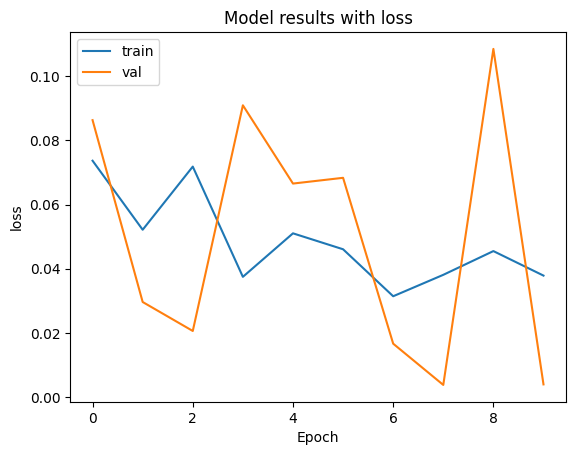

In [141]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

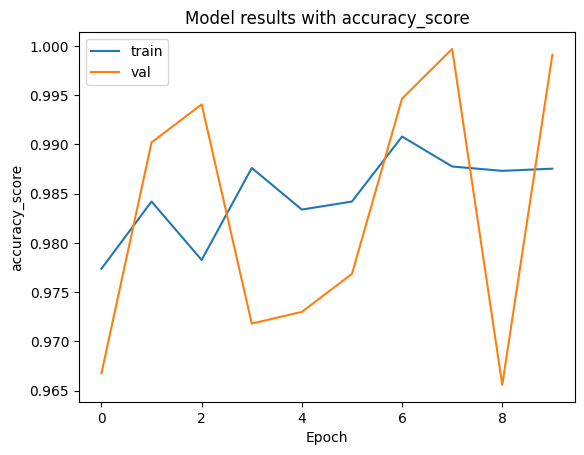

In [142]:
plot_metric(history, 'accuracy_score')

[]

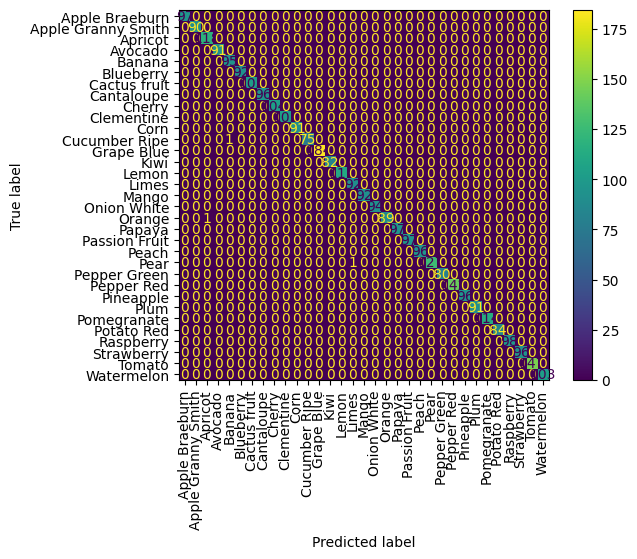

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=val_data.classes)
plt.xticks(rotation=90)
plt.plot()

In [144]:
y_pred[0].sum()

0.99999994

In [146]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=val_data.classes))

                    precision    recall  f1-score   support

    Apple Braeburn       1.00      1.00      1.00        97
Apple Granny Smith       1.00      1.00      1.00        90
           Apricot       0.99      1.00      1.00       118
           Avocado       1.00      1.00      1.00        91
            Banana       0.99      1.00      0.99        95
         Blueberry       1.00      1.00      1.00        92
      Cactus fruit       1.00      1.00      1.00       103
        Cantaloupe       1.00      1.00      1.00        96
            Cherry       1.00      1.00      1.00       104
        Clementine       1.00      1.00      1.00       103
              Corn       1.00      1.00      1.00        91
     Cucumber Ripe       1.00      0.99      0.99        76
        Grape Blue       1.00      1.00      1.00       184
              Kiwi       1.00      1.00      1.00        82
             Lemon       1.00      1.00      1.00       111
             Limes       0.99      1.00